In [10]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/

In [11]:
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

100% 246M/247M [00:08<00:00, 29.7MB/s]
100% 247M/247M [00:08<00:00, 31.0MB/s]


In [ ]:
! unzip satellite-images-of-water-bodies.zip

In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm
import matplotlib.pyplot as plt

In [14]:
image_dir = '/content/Water Bodies Dataset/Images'
masks_dir = '/content/Water Bodies Dataset/Masks'

In [96]:
samples = next(os.walk(image_dir))[-1][:20]
masks= next(os.walk(masks_dir))[-1][:20]

In [97]:
j = 0
dir = image_dir 
samples_ = np.zeros(shape=(len(samples),256,256, 3))
for f in range(len(samples)):
  image = tf.io.read_file(os.path.join (dir, samples[f]))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (256, 256),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  samples_[j] = tf.cast(image, tf.float32) / 255.0
  j = j + 1

In [98]:
j = 0
dir = masks_dir 
masks_ = np.zeros(shape=(len(samples),256,256, 3))
for f in range(len(samples)):
  image = tf.io.read_file(os.path.join (dir, samples[f]))
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (256, 256),method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  masks_[j] = tf.cast(image, tf.float32) / 255.0
  j = j + 1

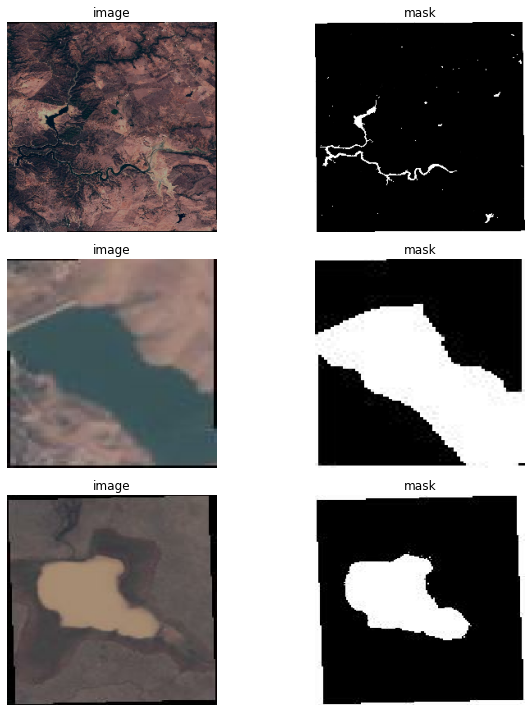

In [100]:
plt.figure(figsize=(10,10))
for i in range(1,7):
    plt.subplot(3,2,i)
    
    if i%2!=0:
        id = np.random.randint(len(samples_))
        plt.imshow(samples_[id])
        plt.title('image')
        plt.axis('off')
    elif i%2==0:
        plt.imshow(masks_[id])
        plt.title('mask')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [101]:
import os
import random
import shutil

# Set the path to your directory containing the images
directory_path = image_dir

# Set the percentage of images to use for validation
validation_percentage = 0.2

# Create a directory for the validation images
os.makedirs(os.path.join(directory_path, "val"))

# Get a list of all the image filenames in the directory
image_filenames = os.listdir(directory_path)

# Calculate the number of images to use for validation
num_validation_images = int(len(image_filenames) * validation_percentage)

# Randomly select the validation images and move them to the validation directory
for i in range(num_validation_images):
    filename = image_filenames[i]
    source_path = os.path.join(directory_path, filename)
    dest_path = os.path.join(directory_path, "val", filename)
    shutil.move(source_path, dest_path)
    image_filenames.remove(filename)


In [102]:
import os
import random
import shutil

# Set the path to your directory containing the images
directory_path = masks_dir

# Set the percentage of images to use for validation
validation_percentage = 0.2

# Create a directory for the validation images
os.makedirs(os.path.join(directory_path, "val"))

# Get a list of all the image filenames in the directory
image_filenames = os.listdir(directory_path)

# Calculate the number of images to use for validation
num_validation_images = int(len(image_filenames) * validation_percentage)

# Randomly select the validation images and move them to the validation directory
for i in range(num_validation_images):
    filename = image_filenames[i]
    source_path = os.path.join(directory_path, filename)
    dest_path = os.path.join(directory_path, "val", filename)
    shutil.move(source_path, dest_path)
    image_filenames.remove(filename)


In [82]:
from tensorflow.python.ops.random_ops import categorical
from keras.preprocessing.image import ImageDataGenerator
import cv2

# create an instance of the ImageDataGenerator class with desired data augmentation parameters
data_gen_args = dict(rescale = 1./255,
                    rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='nearest')

# include histogram equalization in the preprocessing step
def histeq(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output

# include image scaling and resizing in the preprocessing step
def scale_resize(img, scale=0.5, width=512, height=512):
    img = cv2.resize(img, (0, 0), fx=scale, fy=scale)
    img = cv2.resize(img, (width, height))
    return img

# create an instance of the ImageDataGenerator class with the specified preprocessing functions
image_datagen = ImageDataGenerator(preprocessing_function=histeq , **data_gen_args )
mask_datagen = ImageDataGenerator(**data_gen_args )

# specify the directory where your original images and segmentation masks are located


# create a generator for the original images
image_generator = image_datagen.flow_from_directory(
    image_dir,
    class_mode='categorical',
    seed=42)

# create a generator for the segmentation masks
mask_generator = mask_datagen.flow_from_directory(
    masks_dir,
    class_mode='categorical',
    seed=42)



# specify the number of augmented images you want to generate



Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
